In [1]:
import sys
sys.path.append('../..')

In [2]:
from skactiveml.pool import RandomSampler

In [27]:
RandomSampler(batch_size=2, random_state=1).query([[1],[1],[1],[1],[1]],
                                                  return_utilities=False)

array([1, 0])

In [32]:
import numpy as np

from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from skactiveml.pool import UncertaintySampling, ExpectedErrorReduction, ALCE, \
    McPAL, RandomSampler, EpistemicUncertainty, FourDS,
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

# Generate data set.
X, y_true = make_blobs(random_state=0, centers=5, shuffle=True)
X = StandardScaler().fit_transform(X)
y = np.full(shape=y_true.shape, fill_value=-1)
y[:20] = y_true[:20]

# Create classifier and query strategy.
clf = SklearnClassifier(MLPClassifier(random_state=0, max_iter=10000),
                        classes=np.unique(y_true), missing_label=-1,
                        random_state=0)
qs = UncertaintySampling(random_state=0)

# Execute active learning cycle.
n_cycles = 10
for c in range(n_cycles):
     clf.fit(X, y)
     unlbld_idx = unlabeled_indices(y, missing_label=-1)
     X_cand = X[unlbld_idx]
     t = time()
     query_idx = unlbld_idx[qs.query(X_cand=X_cand, clf=clf, batch_size=5)]
     print(time()-t)
     y[query_idx] = y_true[query_idx]
print(f'Accuracy: {clf.score(X, y_true)}')


SyntaxError: trailing comma not allowed without surrounding parentheses (2995197618.py, line 11)

In [38]:
from torch import nn
from skorch import NeuralNetClassifier
from skactiveml.classifier import PWC

# Generate data set.
X, y_true = make_blobs(random_state=0, centers=5, shuffle=True)
y_true %= 2
X = StandardScaler().fit_transform(X)
y = np.full(shape=y_true.shape, fill_value=-1)
#y[:50] = y_true[:50]

X = X.astype(np.float32)
y = y.astype(np.int64)
y_true = y_true.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=100, nonlin=nn.ReLU()):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(2, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=50,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=False,
    train_split=False
)

pwc = PWC(class_prior=0, classes=np.unique(y_true), missing_label=-1)
clf = SklearnClassifier(net, classes=np.unique(y_true), missing_label=-1,
                        random_state=0)
qs = UncertaintySampling(random_state=0)

# Execute active learning cycle.
n_cycles = 25
for c in range(n_cycles):
     clf.fit(X, y)
     unlbld_idx = unlabeled_indices(y, missing_label=-1)
     X_cand = X[unlbld_idx]
     t = time()
     query_idx = unlbld_idx[qs.query(X_cand=X_cand, clf=pwc, X=X, y=y,
                                     batch_size=1)]
     print(time()-t)
     y[query_idx] = y_true[query_idx]
print(f'Accuracy: {clf.fit(X, y).score(X, y_true)}')


0.005366802215576172


/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:259: UserWarning: The 'base_estimator' could not be fitted because of 'num_samples should be a positive integer value, but got num_samples=0'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0]`.
  warnings.warn("The 'base_estimator' could not be fitted because of"


0.005888223648071289
0.003514528274536133
0.0031244754791259766
0.0032498836517333984
0.006188869476318359
0.0041658878326416016
0.003576993942260742
0.0053863525390625
0.0036351680755615234
0.005046844482421875
0.0064313411712646484
0.004711627960205078
0.0038118362426757812
0.00393986701965332
0.004993438720703125
0.005129575729370117
0.003937721252441406
0.004674196243286133
0.004380941390991211
0.004061460494995117
0.0040204524993896484
0.0037920475006103516
0.004462718963623047
0.0037102699279785156
Accuracy: 0.79


In [14]:
from sklearn.utils.validation import check_array

X, y_true = make_blobs(random_state=0, centers=5, shuffle=True)
y_true %= 2
X = StandardScaler().fit_transform(X)
y = np.full(shape=y_true.shape, fill_value=-1)
y[:50] = y_true[:50]

X = X.astype(np.float32)
y = y.astype(np.int64)
y_true = y_true.astype(np.int64)

X = check_array(X)
print(X.dtype)

float32


bandwidth: 0.2630154484476343
0.0


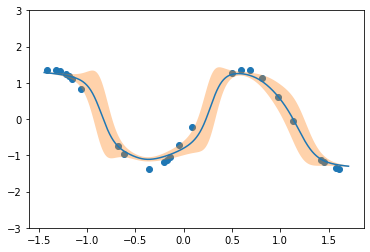

In [3]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels, KERNEL_PARAMS
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted, check_scalar
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman1, make_regression
import matplotlib.pyplot as plt
from scipy.stats import t

from skactiveml.utils import MISSING_LABEL


class PWR:
    METRICS = list(KERNEL_PARAMS.keys()) + ['precomputed']

    def __init__(self, n_neighbors=None, metric='rbf', metric_dict=None):
        self.metric = metric
        self.n_neighbors = n_neighbors
        self.metric_dict = {} if metric_dict is None else metric_dict

    def fit(self, X, y):
        self.X_ = X.copy()
        self.y_ = y.copy()

        return self

    def predict_freq(self, X):
        K = pairwise_kernels(X, self.X_, metric=self.metric,
                             **self.metric_dict)


        # maximum likelihood
        N = np.sum(K, axis=1)
        mu_ml = K @ self.y_ / N
        sigma_ml = np.sqrt((K @ self.y_**2 / N) - mu_ml**2)

        # normal
        mu_0 = 0
        sigma_0 = 1
        mu_N = ((sigma_ml**2) / (N * sigma_0**2 + sigma_ml**2)) * mu_0 + \
               ((N*sigma_0**2)/(N*sigma_0**2 + sigma_ml**2)) * mu_ml
        sigma_N = ((1 / (sigma_0**2)) + (N/(sigma_ml**2)))**(-1)

        # normal wishart
        mu_0 = 0
        lmbda_0 = 0.001
        alpha_0 = 1
        beta_0 = 0.0001
        mu_N = (lmbda_0 * mu_0 + N * mu_ml) / (lmbda_0 + N)
        lmbda_N = lmbda_0 + N
        # alpha and beta to variance
        alpha_N = alpha_0 + N/2
        beta_N = beta_0 + 0.5 * N*sigma_ml**2 \
                 + 0.5 * (lmbda_0*N*(mu_ml-mu_0)**2)/(lmbda_0 + N)
        df = alpha_N
        loc = mu_N
        scale = (beta_N * (lmbda_N + 1)) / (alpha_N * lmbda_N)
        mean, var, skew, kurt = t.stats(df=5, loc=loc, scale=scale, moments='mvsk')
        print(np.abs(mean - mu_N).sum())
        #return mu_N, (alpha_N * beta_N**(-1))**(-1)
        return mean, np.sqrt(var)

#y[200:400] += np.random.randn(200)
#rand_indices = np.arange(int(len(X)*0.4))
#idx = np.append(rand_indices, np.random.choice(np.arange(400, 800), replace=False,
#                size=int(10)))
x_axis = np.linspace(-5, 5, 100)
y = np.sin(x_axis) + np.random.rand(len(x_axis))*0.001
X = x_axis.reshape(-1, 1)
y = StandardScaler().fit_transform(y.reshape(-1, 1)).ravel()
idx = np.random.choice(np.arange(len(X)), replace=False, size=int(0.25*len(X)))
X_train = X[idx]
y_train = y[idx]

sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X = sc.transform(X)
x_axis = np.linspace(X.min(), X.max(), 1000)

n_samples = len(X_train)
n_features = 1
nominator = 2 * n_samples * n_features
denominator = (n_samples - 1) * np.log((n_samples - 1) / ((np.sqrt(2) * 10 ** -6) ** 2))
bandwidth = np.sqrt(nominator / denominator)
print('bandwidth: {}'.format(str(bandwidth)))
gamma = (bandwidth ** (-2))

pwr = PWR(metric_dict={'gamma': gamma}).fit(X_train, y_train)
y_pred, var_pred = pwr.predict_freq(x_axis.reshape(-1, 1))

n_std = 1
plt.scatter(X_train.flatten(), y_train)
plt.plot(x_axis, y_pred)
plt.err(x_axis, y_pred+n_std*var_pred, y_pred-n_std*var_pred, alpha=0.35)
plt.ylim(-3, 3)
plt.show()